In [3]:
from Bio import SeqIO, Entrez
import os
from urllib.error import HTTPError
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import permutations, product
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
import tqdm
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score

from numpy import mean
from numpy import std
import pickle
from os import path
from sklearn.model_selection import cross_val_score
from warnings import simplefilter
from collections import OrderedDict
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score

from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt


if (os.path.abspath('').split('/')[-1] == 'project'):
    %cd utils
elif (os.path.abspath('').split('/')[-1] == 'validate'):
    %cd ../utils

import query_utils
import model_utils
import validation_utils

if (os.path.abspath('').split('/')[-1] == 'utils'):
    %cd ..


simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)


/Users/benjaminli/Documents/coding/scires/project/utils
/Users/benjaminli/Documents/coding/scires/project


In [4]:
df = pd.read_csv('data/info.csv')
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'isZoonotic'], df['isZoonotic'], test_size=0.6, random_state=None)
# X_test = df.loc[:, df.columns != 'isZoonotic']
# y_test = df['isZoonotic']

In [13]:
curr_dir = 'models/curr_models'
best_xgboost = pickle.load(open(f'{curr_dir}/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open(f'{curr_dir}/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open(f'{curr_dir}/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open(f'{curr_dir}/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open(f'{curr_dir}/randforest.pkl', 'rb'))
lrmodel = pickle.load(open(f'{curr_dir}/lrmodel.pkl', 'rb'))

nardus_gradBoost = pickle.load(open(f'models/nardus_gridsearch.pkl', 'rb'))

mlp = pickle.load(open(f'{curr_dir}/mlpClassifier.pkl', 'rb'))

svmmodel = pickle.load(open(f'{curr_dir}/svm.pkl', 'rb'))

regnard = pickle.load(open(f'models/nardus_testing/gradBoost.pkl', 'rb'))


In [14]:
# Models within "orig_models" folder have the highest training acc but not as great cross validation

nardus_score = validation_utils.cross_validate(nardus_gradBoost.best_estimator_, X_test, y_test)
regnard_score = validation_utils.cross_validate(regnard, X_test, y_test)

# val_utils.cross_validate(mlp,X_test, y_test)

# xg_score = validation_utils.cross_validate(best_xgboost,X_test, y_test)
grad_score = validation_utils.cross_validate(best_gradBoost,X_test, y_test)
rf_score = validation_utils.cross_validate(best_rF,X_test, y_test)
lr_score = validation_utils.cross_validate(lrmodel,X_test, y_test)

GradientBoostingClassifier
gradboost
Accuracy: 0.956 (0.008)
tn: 4884, fp: 10, fn: 35, tp: 729
GradientBoostingClassifier
gradboost
Accuracy: 0.957 (0.009)
tn: 4877, fp: 17, fn: 27, tp: 737
GradientBoostingClassifier
gradboost
Accuracy: 0.954 (0.009)
tn: 4888, fp: 6, fn: 35, tp: 729
BalancedBaggingClassifier
Accuracy: 0.921 (0.013)
tn: 4692, fp: 202, fn: 27, tp: 737
LogisticRegression
Accuracy: 0.933 (0.009)
tn: 4790, fp: 104, fn: 762, tp: 2


GradientBoostingClassifier
gradboost
precision recall: 0.9898525767389625
[0.00079958 0.00927168 0.00912342 ... 0.13999619 0.0013175  0.00121336]
XGBClassifier
xgboost
precision recall: 0.9916005474310688
[6.6448833e-05 6.2821106e-05 5.0032837e-03 ... 7.4697873e-03 2.9495259e-05
 2.7833995e-04]
GradientBoostingClassifier
gradboost
precision recall: 0.9899240409764989
[0.00124514 0.00295339 0.06607803 ... 0.0349055  0.00135243 0.00372242]
BalancedBaggingClassifier
precision recall: 0.9664320409489697
[0.  0.3 0.4 ... 0.5 0.  0. ]
LogisticRegression
precision recall: 0.09897140225221193
[2.02785803e-01 4.38443448e-04 2.97469610e-04 ... 9.48983990e-05
 6.90090209e-03 6.32422623e-03]
MLPClassifier
precision recall: 0.9789288354559714
[4.18976440e-12 6.49688308e-09 2.20434355e-03 ... 8.33179892e-01
 2.93115551e-05 8.83359436e-06]
SVC
precision recall: 0.8524585962282091
[0.00189695 0.00285606 0.05759084 ... 0.0524386  0.01375476 0.02083042]
GradientBoostingClassifier
gradboost
precision rec

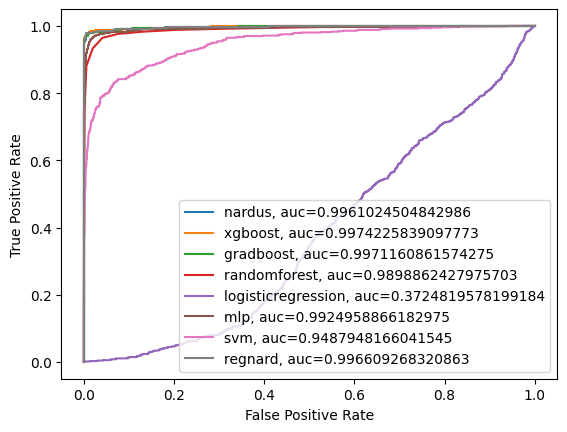

In [15]:
models = {
    "nardus": nardus_gradBoost.best_estimator_,
    "xgboost": best_xgboost,
    "gradboost": best_gradBoost,
    "randomforest": best_rF,
    "logisticregression": lrmodel,
    "mlp": mlp,
    "svm": svmmodel,
    "regnard": regnard
}

validation_utils.draw_roc_multiple(models, X_test, y_test)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


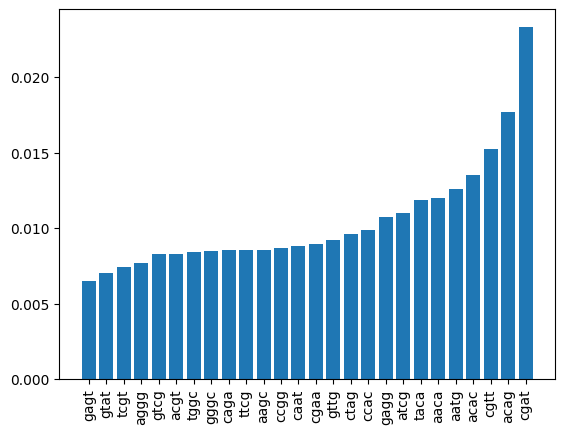

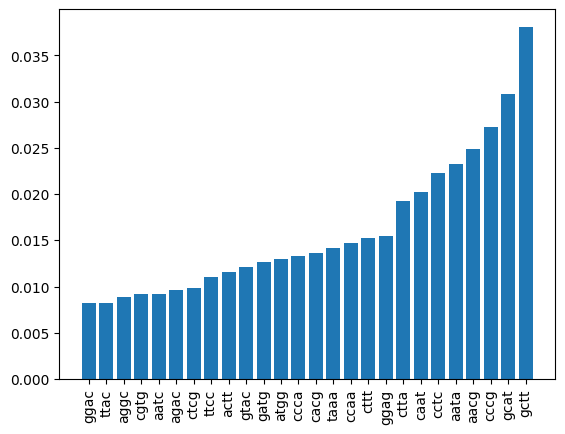

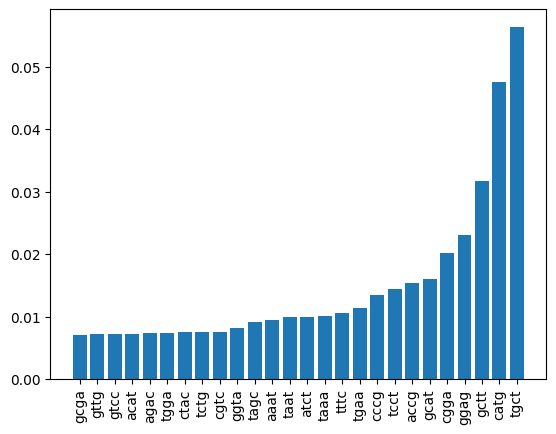

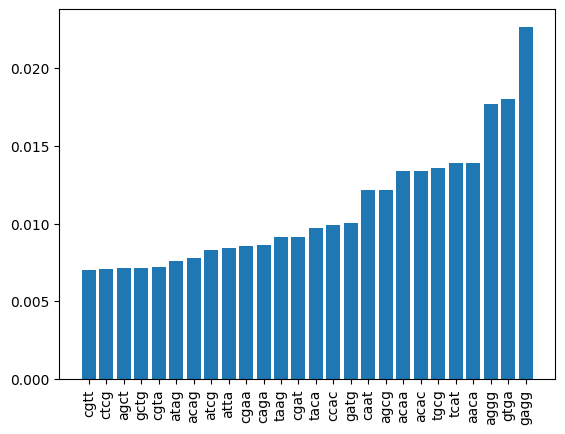

In [16]:
"""
validation_utils.draw_roc_curve(nardus_gradBoost.best_estimator_, X_test, y_test)
validation_utils.draw_roc_curve(best_xgboost, X_test, y_test)
validation_utils.draw_roc_curve(best_rF, X_test, y_test)
validation_utils.draw_roc_curve(best_gradBoost, X_test, y_test)
validation_utils.draw_roc_curve(mlp, X_test, y_test)

"""
print(type(nardus_gradBoost.best_estimator_))
validation_utils.draw_feature_importances(nardus_gradBoost.best_estimator_, X_test)
validation_utils.draw_feature_importances(best_gradBoost, X_test)
validation_utils.draw_feature_importances(best_xgboost, X_test)
validation_utils.draw_feature_importances(regnard, X_test)

In [ ]:
max_bound = 3
for x in range(len(resrF)-max_bound+1):
    for i in range(max_bound):
        if resrF[x][0] == resgB[x+i][0]:  print("rF & gb bound", i, resrF[x], x)
        if resrF[x][0] == resxG[x+i][0]:  print("rF & xg bound", i, resrF[x], x)
        if resgB[x][0] == resxG[x+i][0]:  print("gb & xg bound", i, resgB[x], x)

rF & gb bound 1 ('cgcg', 0.0003015572826893574) 12
rF & xg bound 0 ('cgac', 0.0005925319998248206) 21
rF & gb bound 1 ('tatt', 0.0011150453509348468) 60
rF & gb bound 0 ('ctcg', 0.001601226302398424) 96
rF & xg bound 2 ('taac', 0.0016960808192351047) 105
rF & xg bound 1 ('caaa', 0.0018456698283735272) 115
gb & xg bound 1 ('agct', 0.002219047867503112) 122
rF & xg bound 1 ('ctca', 0.0020714853411268937) 132
rF & gb bound 2 ('gaac', 0.0025670387790062968) 151
gb & xg bound 0 ('taag', 0.014197001200931161) 244
